# Introduction
In this notebook we will try to predict the stator temperature of a permanent magnet synchronous motor (PMSM) deployed on a test bench.
As suggested in the explanatory notes of the dataset, the metrics "rotor temperature", "stator temperature" and "torque" are hard to measure in practical applications. A sufficiently accurate prediction model would therefore eliminate the need for actual measurements to determine the stator temperature.

Please feel free to comment on any possible additions or improvements.

In [1]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bottleneck as bn # library used for moving average

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers import Dense, Dropout,BatchNormalization
from keras.regularizers import l2
from keras.layers import LSTM
from keras.layers import Dropout
import subprocess

# Exploring the data

In [5]:
# load the dataset into a pandas dataframe
dataset = pd.read_csv('pmsm_temperature_current_data.csv')
dataset.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding_temp,testrun_id,CH1,CH2,CH3,CH4
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4,1.584,0.68,0.80,1.54
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4,1.584,0.68,0.82,1.54
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4,1.584,0.68,0.84,1.52
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4,1.568,0.66,0.84,1.50
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4,1.568,0.68,0.86,1.50


In [6]:
# check if the dataset contains NaN values
dataset.isnull().values.any()

False

In [7]:
dataset.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding_temp,testrun_id,CH1,CH2,CH3,CH4
count,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000,998070.000000
mean,-0.003905,0.004723,0.004780,-0.005690,-0.006336,-0.003333,0.006043,-0.003194,-0.004396,0.000609,-0.002208,-0.003935,50.732001,1.622008,1.688699,1.684360,1.676632
std,0.993127,1.002423,0.997878,1.002330,1.001229,0.997907,0.998994,0.997912,0.995686,1.001049,0.999597,0.998343,22.073125,0.111154,0.766322,0.748505,0.744770
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.371529,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973,4.000000,1.240000,0.540000,0.540000,0.560000
25%,-0.599385,-1.037925,-0.826359,-0.927390,-0.951892,-0.266917,-0.756296,-0.257269,-0.672308,-0.747265,-0.761951,-0.725622,32.000000,1.536000,0.920000,0.940000,0.920000
50%,0.266157,-0.177187,0.267542,-0.099818,-0.140246,-0.187246,0.213935,-0.190076,0.094367,-0.057226,0.005085,0.006536,56.000000,1.624000,1.680000,1.680000,1.680000
75%,0.686675,0.650709,0.358491,0.852625,0.853584,0.547171,1.013975,0.499260,0.680691,0.697344,0.772239,0.725660,68.000000,1.704000,2.480000,2.440000,2.420000
max,2.967117,2.649032,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781,81.000000,1.992000,2.820000,2.820000,2.800000


In [8]:
# plot the boxplots of all features
#plt.tight_layout(pad=0.9)
#plt.figure(figsize=(20,15)) 
#plt.subplots_adjust(wspace = 0.2)
#nbr_columns = 4 
#nbr_graphs = len(dataset.columns)
#nbr_rows = int(np.ceil(nbr_graphs/nbr_columns)) 
#columns = list(dataset.columns.values) 
#with sns.axes_style("whitegrid"):
    #for i in range(0,len(columns)-1): 
      #  plt.subplot(nbr_rows,nbr_columns,i+1) 
      #  ax1=sns.boxplot(x= columns[i], data= dataset, orient="h",color=sns.color_palette("Blues")[3]) 
   # plt.show() 

In [9]:
# plotting the Correlation matrix
#fig = plt.figure(figsize=(12,9))
#sns.heatmap(dataset.corr(),annot=True)
#plt.show()

In [10]:
# print the list of all testruns
#testrun_id_list = dataset.testrun_id.unique()
#print(testrun_id_list)
#print("amount of test runs: {0}".format(testrun_id_list.size))

After exploring the dataset, following observations can be made: 
* The various testruns (52 in total) are labelled by the profile_id (as mentioned in the dataset description). The indexes for these testruns however, are not incremental.
* The dataset description provides us with no references to the units used for each of the samples, making it harder to interpret the values measured. 
* When we look at the statistical overview of the dataset and the histograms, it seems the dataset already has had some kind of normalisation. 
* Features like torque, motor speed, rotor temperature (pm), stator yoke, winding and tooth temperature (resp. stator_yoke, stator_winding, stator_tooth), coolwater temperature (coolant) are all reasonably self-explanatory. The active and reactive current and voltage (resp. i_d,i_q,u_d,u_q) of the PMSM however, require some background knowledge of how a synchronous motor works.
* The ambient temperature is measured by a thermal sensor located closely to the stator (as stated in the explanatory notes of the dataset). We can therefore assume that this will have an impact on the selfcooling capacity of the motor. A higher ambient temperature will probably result in a higher temperature for both the motor's stator and rotor.
* The correlation matrix shows that there is a significant correlation between the three different stator temperatures.


# Predicting the stator winding leakage current


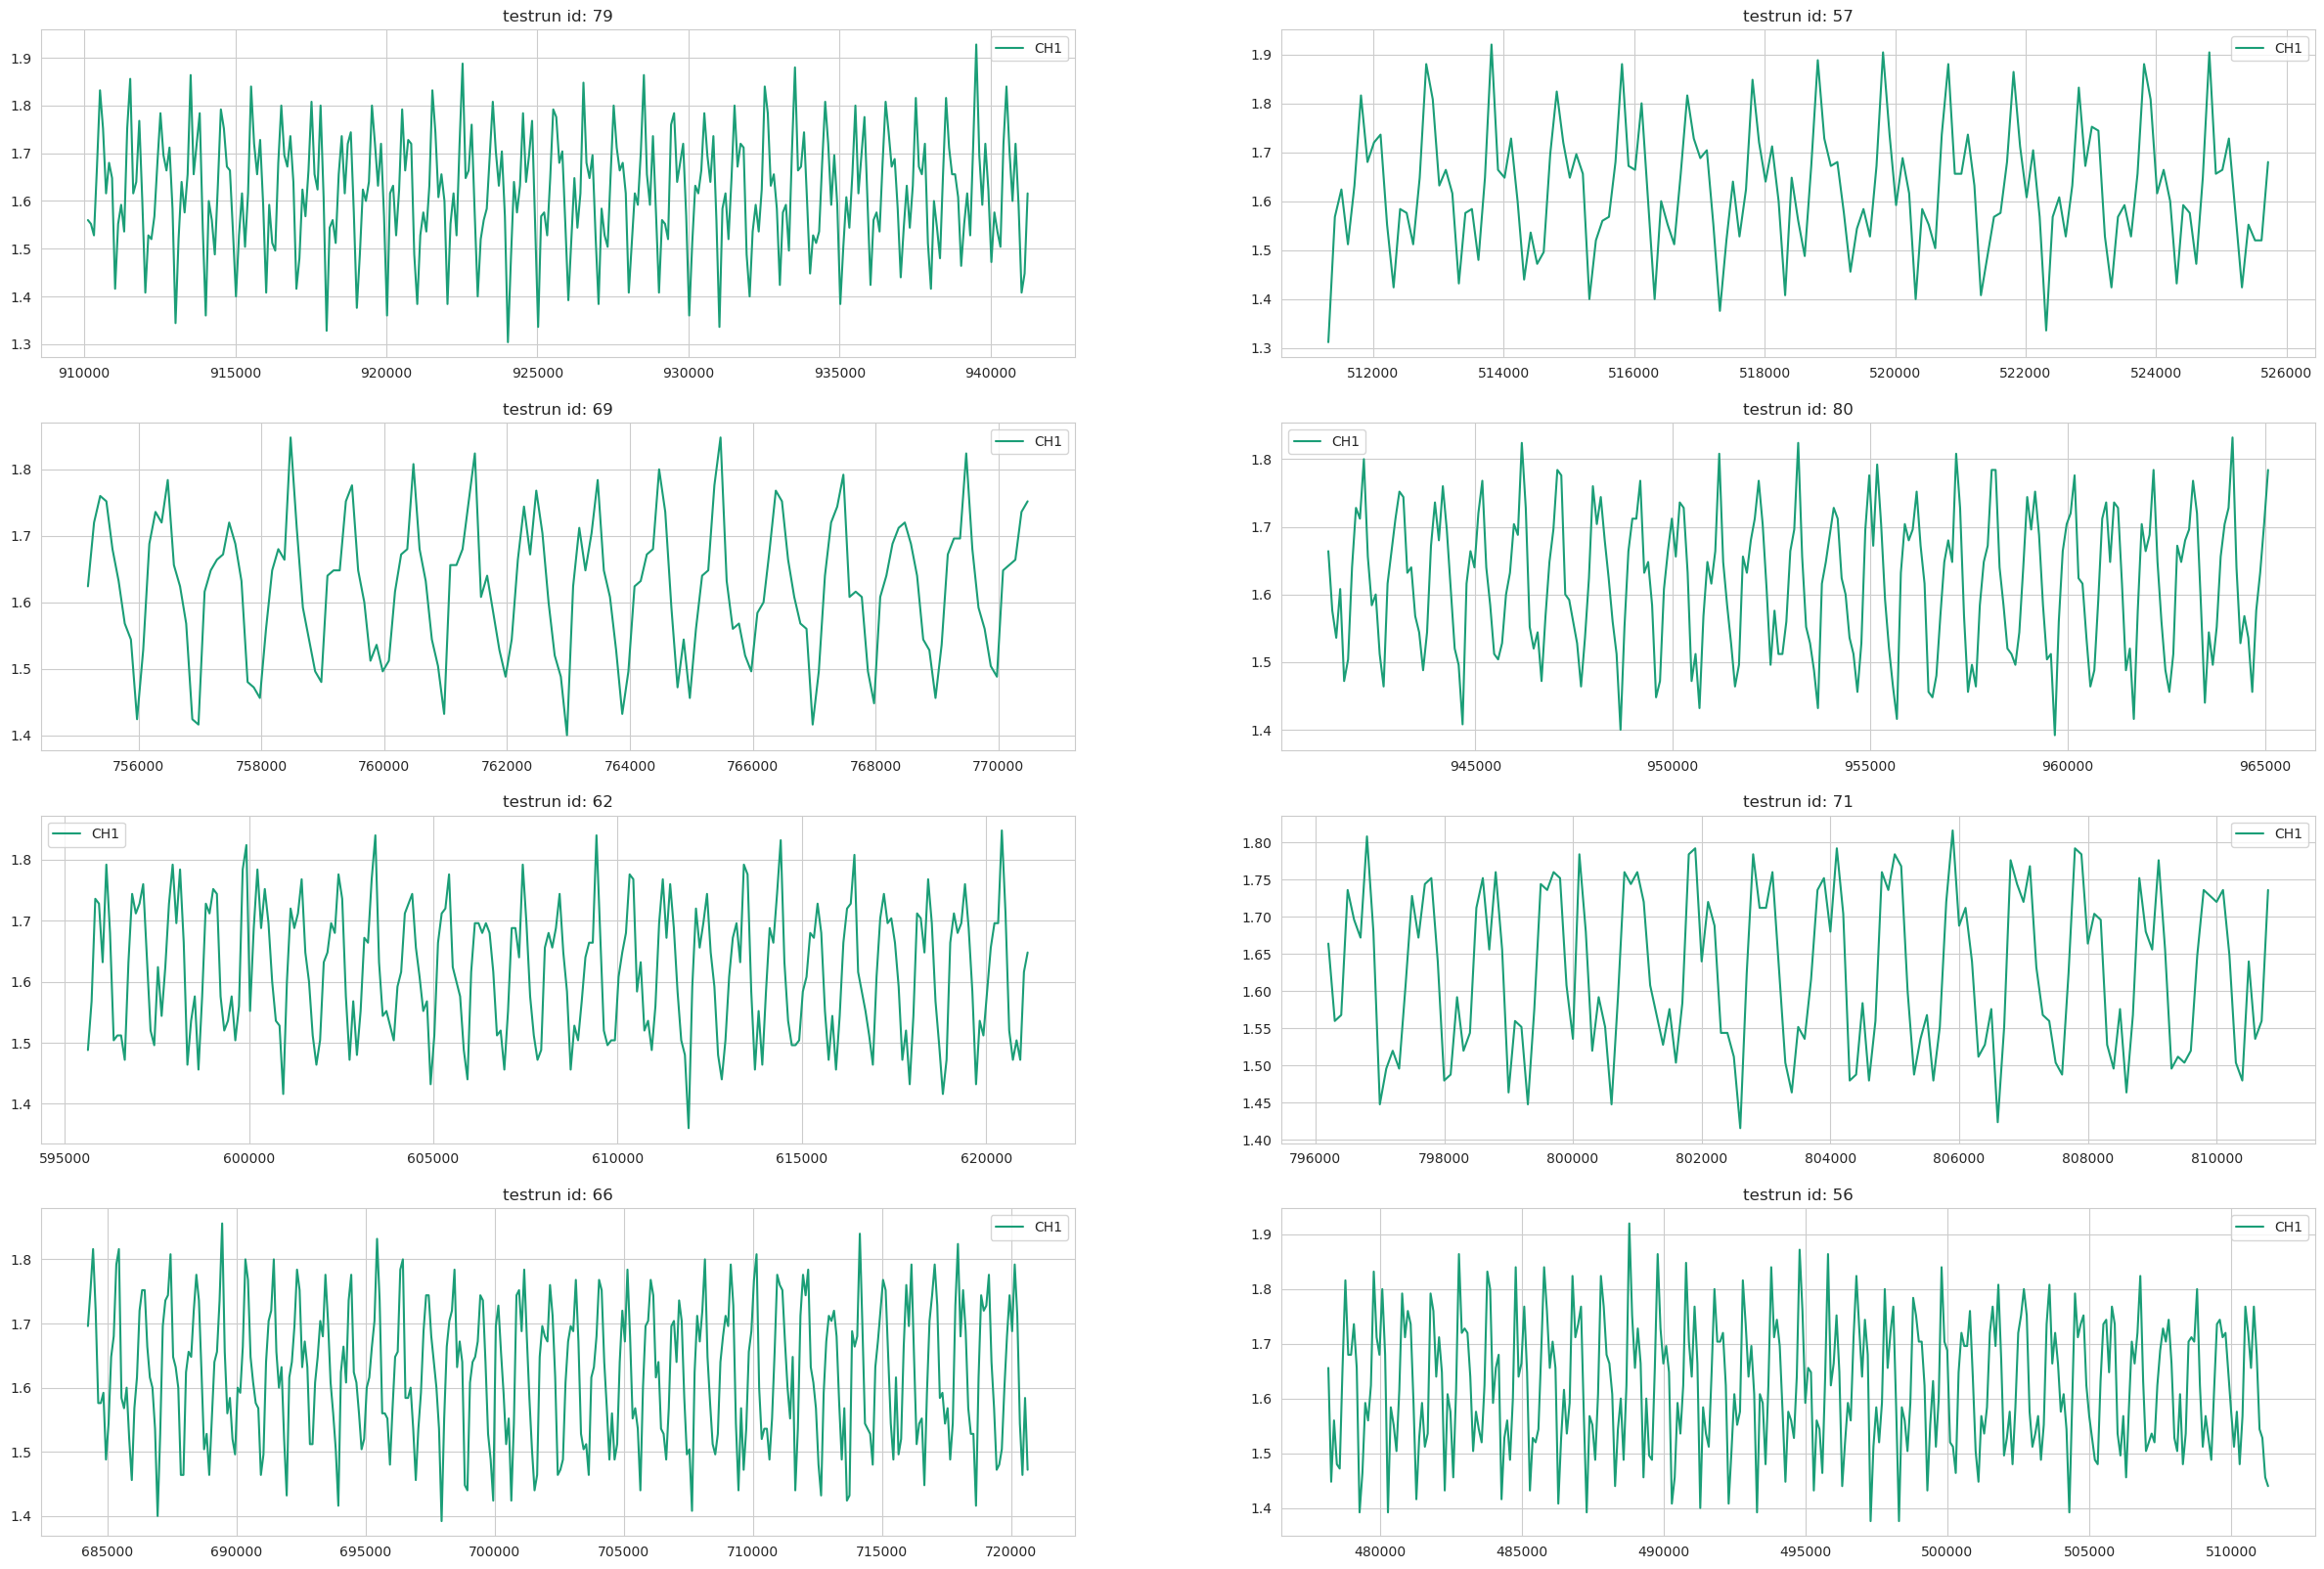

In [11]:
# plotting 'stator_yoke','stator_tooth','stator_winding' for a random set of testruns
columns = ['CH1']
testrun_id_list = dataset.testrun_id.unique()
testrun_id_list = np.random.choice(testrun_id_list, size=8, replace=False)    
nbr_column = 2 
nbr_graph= len(testrun_id_list) 
nbr_row = int(np.ceil(nbr_graph/nbr_column)) 
kolomlijst = list(dataset.columns.values) 
plt.figure(figsize=(30,nbr_row*5)) 
    
with sns.axes_style("whitegrid"):    
    for i in range(0,nbr_graph): 
        plt.subplot(nbr_row,nbr_column,i+1) 
        temp = dataset.loc[dataset['testrun_id'] == testrun_id_list[i]]
        temp = temp.loc[:,columns]
        temp = temp.iloc[::100, :]
        ax1=sns.lineplot(data=temp.loc[:,columns], 
                        dashes = False,
                        palette=sns.color_palette('Dark2',n_colors=len(columns)))
        ax1.set_title("testrun id: {0}".format(testrun_id_list[i]))
    plt.show    
  

The lineplots confirm that all three temperatures follow the same trend. The stator winding temperatures shows the biggest variation followed by the stator tooth and stator yoke temperature. This is especially noticeable when there is a lot of variation in the stator winding temperature. If this is the case, the stator tooth and yoke temperatures follow a smoother path than the temperature recorded on the stator winding. In other words, the heat dissipated by the stator windings takes some time to heat up the stator tooth and yoke due to the thermal inertia of both stator parts.

A second observation that can be made on the various lineplots is that sometimes the stator yoke temperature has a higher value than the stator winding. Because of the presumed normalisation mentioned earlier, we can not determine whether this is due to the normalisation method used or whether these values actually represent higher temperatures measured on the stator yoke. 

In [12]:
# plotting the stator winding temperature in comparison to torque and motorspeed
#testrun_id = 44
#feat_plot_1 = ['stator_winding_temp']
#feat_plot_2 = ['torque','motor_speed']
#temp = dataset.loc[dataset['testrun_id'] == testrun_id]
#temp = temp.iloc[::10, :]

#with sns.axes_style("whitegrid"):
 #   fig = plt.figure(figsize=(20, 10))
  #  ax1 = fig.add_subplot(211)
   # ax1 = sns.lineplot(data=temp.loc[:,feat_plot_1], dashes = False,
                      # palette=sns.color_palette('Dark2',n_colors=len(feat_plot_1)),linewidth=0.8)
   # ax2 = fig.add_subplot(212)
   # ax2 = sns.lineplot(data=temp.loc[:,feat_plot_2], dashes = False,
                      # palette=sns.color_palette('Dark2',n_colors=len(feat_plot_2)),linewidth=0.8)
   # plt.show()

In the second part of the above testrun there seems to be a relation between the stator temperatures, torque and motorspeed. When the torque and/or motorspeed is increased the temperature rises and vice versa. The temperatures follow the change in torque and/or motorspeed in what seems a  $1-e^{t}$ type of equation. However, looking at the first part of the plot, this is not always the case. Even with constant torque and motor speed the stator winding temperature shows several sudden changes in temperature. In other words, there seem to be one or more other variables which have an impact on the stator temperature.

# Predicting the Stator winding leakage current
Because measuring the torque, rotor and stator temperatures of the electromotor is not reliable nor economically feasible in commercial applications (as stated in the dataset description), we will try to predict the stator temperature by using the other available features in the dataset.  We will start with removing the torque, rotor and stator temperatures from our dataset and use the stator winding temperature as our target value. 

Once this is done, we will train multiple models to predict the correct stator winding temperature as an output value for the input variables given.

##  Random Forest Regressor

We start by training a Random Forest Regressor model.  

In [13]:
# Seperating input and output variables
X = dataset.drop('torque', axis=1).loc[:,'ambient':'i_q'].values 
y = dataset.loc[:,'CH1'].values 

# split up in training and test data
X_train, X_test,y_train, y_test = train_test_split(X, y, test_size=0.3)

In [14]:
X.shape

(998070, 7)

In [15]:
# training the Random Forest Regressor on the dataset
from sklearn.ensemble import RandomForestRegressor
#RFR_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
RFR_model = RandomForestRegressor(n_estimators = 10, random_state = 0)
RFR_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=0)

In [16]:
# Calculate MSE and MAE for the entire testset
y_pred = RFR_model.predict(X_test)
RFR_MSE = mean_squared_error(y_test, y_pred)
RFR_MAE = mean_absolute_error(y_test, y_pred)
print("MSE: {0}".format(RFR_MSE))
print("MAE: {0}".format(RFR_MAE))

MSE: 0.006739284367629525
MAE: 0.06162514185711756


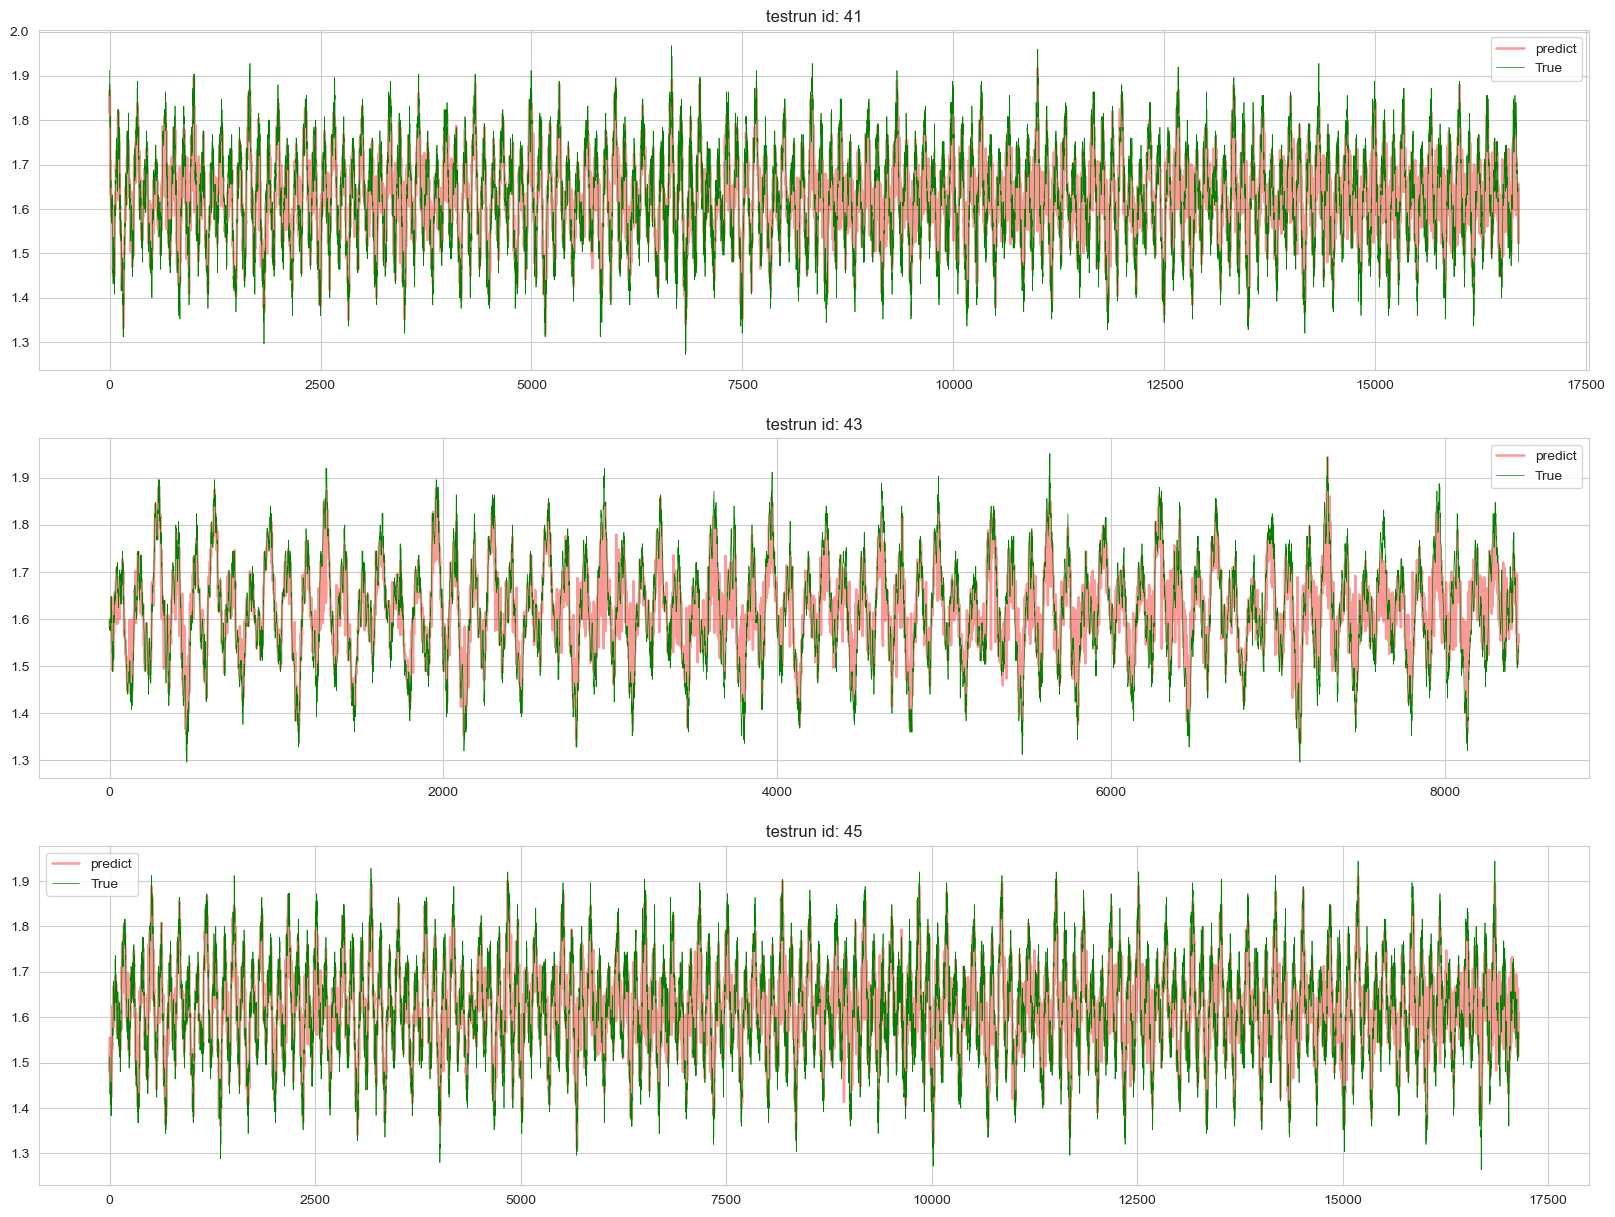

In [17]:
# plot the true vs predicted values for multiple testruns
test_run_list = np.array([41,43,45])
#test_run_list = np.random.choice(profile_id_list, size=4, replace=False)]
output_value = 'CH1'
model = RFR_model

with sns.axes_style("whitegrid"):    
    fig, axs = plt.subplots(len(test_run_list),1,figsize=(20,len(test_run_list)*5),squeeze=False)
    
    for i in range(0,len(test_run_list)):
        X_plot = dataset.drop('torque', axis=1).loc[dataset['testrun_id'] == test_run_list[i],'ambient':'i_q'].values 
        y_plot = dataset.loc[dataset['testrun_id'] == test_run_list[i],output_value].values 
        y_pred_plot = model.predict(X_plot)

        time = np.linspace(0, y_plot.shape[0],num=y_plot.shape[0])
        axs[i,0].plot(time,y_pred_plot,label='predict',color='red',alpha=0.4,linewidth=1.8)
        axs[i,0].plot(time,y_plot,label='True',color='green',linewidth=0.5)
        axs[i,0].legend(loc='best')
        axs[i,0].set_title("testrun id: {0}".format(test_run_list[i]))
    plt.show()   

The graphs depicted above show the true stator winding temperature in comparison to the values predicted by the Random Forest Regressor. As we can see, the Random Forest Regressor seems to be able to capture the global trend in the stator winding value but still there is a lot of noise in the predicted values, especially when the true signal shows a lot of variation. 
To filter out the noise generated by the model, we will apply a moving average function to the output signal.

In [18]:
# This is the testrun we will use as an example for the evaluation of the models
# change this value to use a different testrun
choosen_example_testrun = 67

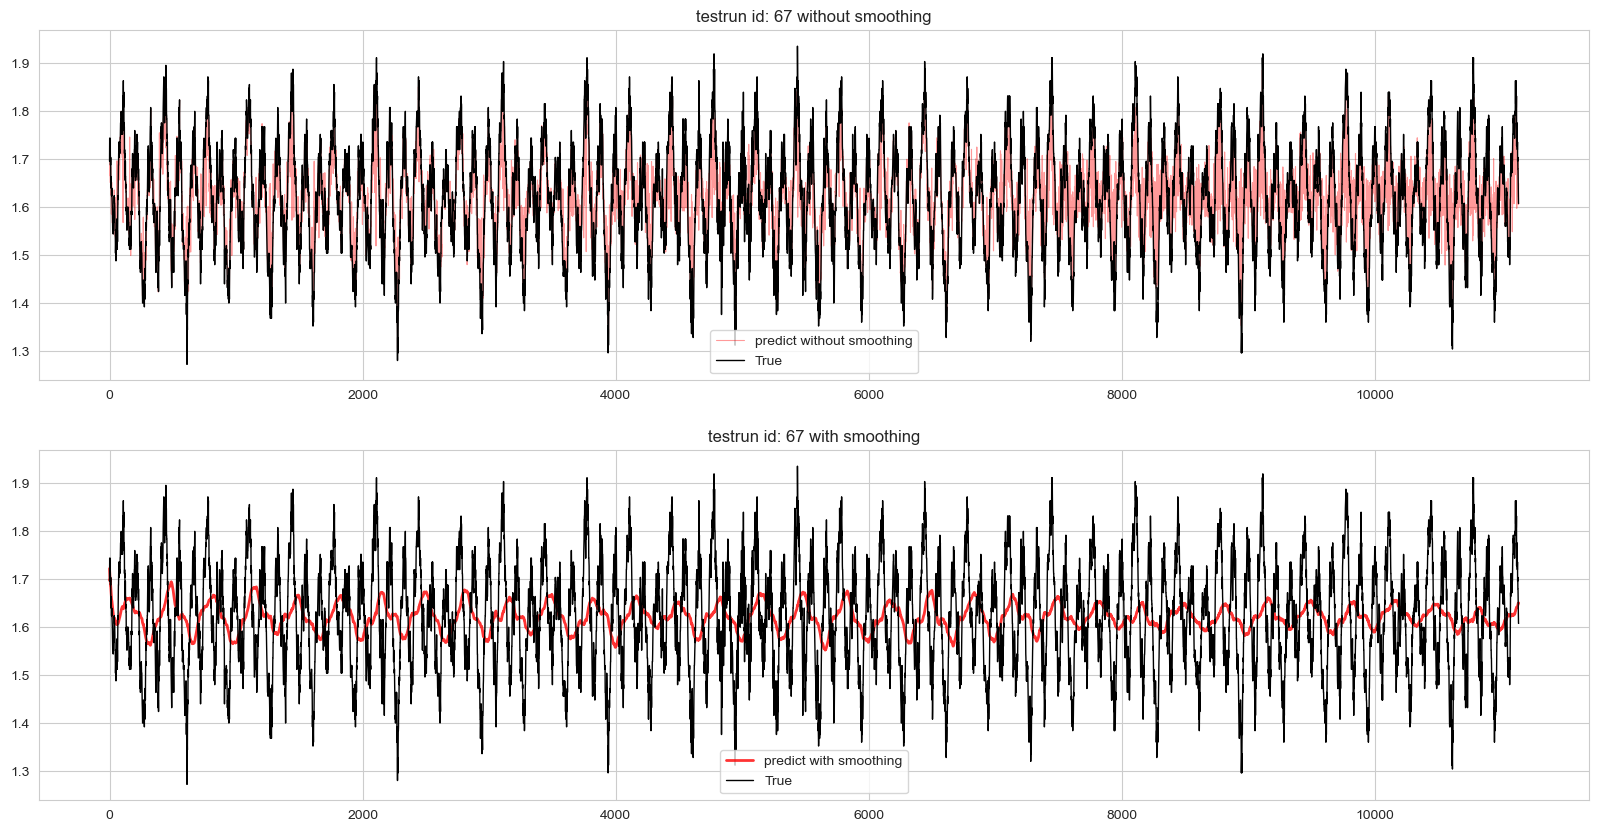

metrics without moving average smoothing:
MSE: 0.003771091877133105
MAE: 0.04161724447637864
metrics with moving average smoothing:
MSE: 0.01286875934223565
MAE: 0.09529140417026198


In [19]:
# plot the true vs predicted values for a choosen testrun without and with moving average smoothing:
testrun_id = choosen_example_testrun
output_value = 'CH1'
model = RFR_model
moving_average_window = 100

X_plot = dataset.drop('torque', axis=1).loc[dataset['testrun_id'] == testrun_id,'ambient':'i_q'].values 
y_plot = dataset.loc[dataset['testrun_id'] == testrun_id,output_value].values 
y_pred_plot = model.predict(X_plot)
y_pred_plot_smooth = bn.move_mean(y_pred_plot,moving_average_window,1)
time = np.linspace(0, y_plot.shape[0],num=y_plot.shape[0])

with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(20, 10))
    
    ax1 = fig.add_subplot(211)
    ax1.plot(time,y_pred_plot,label='predict without smoothing',color='red',alpha=0.4,linewidth=0.8)
    ax1.plot(time,y_plot,label='True',color='black',linewidth=1)
    ax1.legend(loc='best')
    ax1.set_title("testrun id: {0} without smoothing".format(testrun_id))
    
    ax2 = fig.add_subplot(212)
    ax2.plot(time,y_pred_plot_smooth,label='predict with smoothing',color='red',alpha=0.8,linewidth=2)
    ax2.plot(time,y_plot,label='True',color='black',linewidth=1)
    ax2.legend(loc='best')
    ax2.set_title("testrun id: {0} with smoothing".format(testrun_id))
    
    plt.show()

# Calculate MSE and MAE for the choosen testrun without and with moving average smoothing:
MSE_RFR_model = mean_squared_error(y_plot, y_pred_plot)
MAE_RFR_model = mean_absolute_error(y_plot, y_pred_plot)
print("metrics without moving average smoothing:")
print("MSE: {0}".format(MSE_RFR_model))
print("MAE: {0}".format(MAE_RFR_model))
MSE_RFR_model = mean_squared_error(y_plot, y_pred_plot_smooth)
MAE_RFR_model = mean_absolute_error(y_plot, y_pred_plot_smooth)
print("metrics with moving average smoothing:")
print("MSE: {0}".format(MSE_RFR_model))
print("MAE: {0}".format(MAE_RFR_model))

Combined with the moving average function, the Random Forest Regressor gives us a fairly accurate prediction of the stator winding temperature. The moving average has reduced the noise in the predicted output values and has had a positive impact on the MSE for this specific testrun.

## Feed Forward Neural network
Let us now check whether a Feed forward neural network would do better in predicting the stator winding leakage current. Just like with the Random Forest model, we will only use the actual values of the input variables to predict the stator winding leakage current. 

In [20]:
# constructing and training the neural network
nr_epochs=200
b_size=1000

NN_reg_model = Sequential()
NN_reg_model.add(Dense(11, input_dim=X_train.shape[1], activation='relu'))
NN_reg_model.add(Dense(9, activation='relu'))
NN_reg_model.add(Dense(7, activation='relu'))
NN_reg_model.add(Dense(5, activation='relu'))
NN_reg_model.add(Dense(1))
NN_reg_model.compile(loss='mean_squared_error', optimizer='adam',metrics = ["mean_squared_error"])
history = NN_reg_model.fit(X_train, y_train, validation_split=0.33,epochs=nr_epochs, batch_size=b_size, verbose=0)

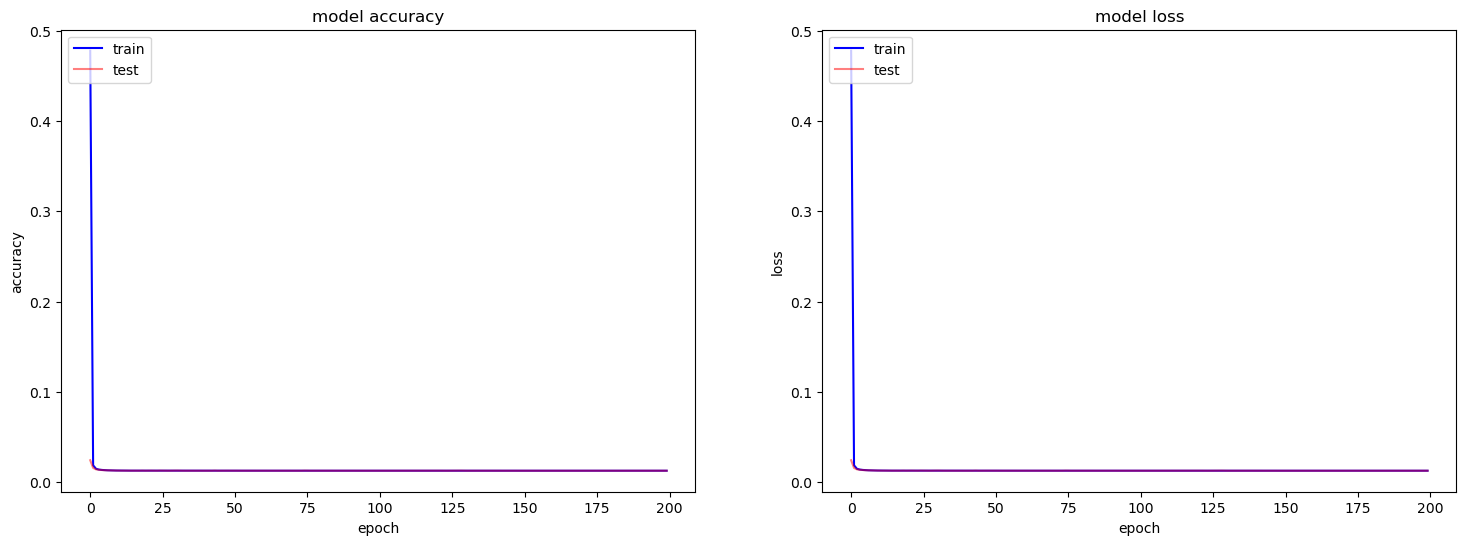

In [21]:
#plot the history of the model accuracy during training
plt.figure(figsize=(18,6))
ax1=plt.subplot(1, 2, 1)
ax1=plt.plot(history.history['mean_squared_error'],color='blue')
ax1=plt.plot(history.history['val_mean_squared_error'],color='red',alpha=0.5)
ax1=plt.title('model accuracy')
ax1=plt.ylabel('accuracy')
ax1=plt.xlabel('epoch')
ax1=plt.legend(['train', 'test'], loc='upper left')

# plot the history of the model loss during training
ax2=plt.subplot(1, 2, 2)
ax2=plt.plot(history.history['loss'],color='blue')
ax2=plt.plot(history.history['val_loss'],color='red',alpha=0.5)
ax2=plt.title('model loss')
ax2=plt.ylabel('loss')
ax2=plt.xlabel('epoch')
ax2=plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
# Calculate MSE and MAE of the entire testset
y_pred = NN_reg_model.predict(X_test)
NN_MSE = mean_squared_error(y_test, y_pred)
NN_MAE = mean_absolute_error(y_test, y_pred)
print("MSE: {0}".format(NN_MSE))
print("MAE: {0}".format(NN_MAE))

9357/9357 [==============================] - 11s 1ms/step
MSE: 0.012318698667748403
MAE: 0.09110657891986346


743/743 [==============================] - 1s 1ms/step


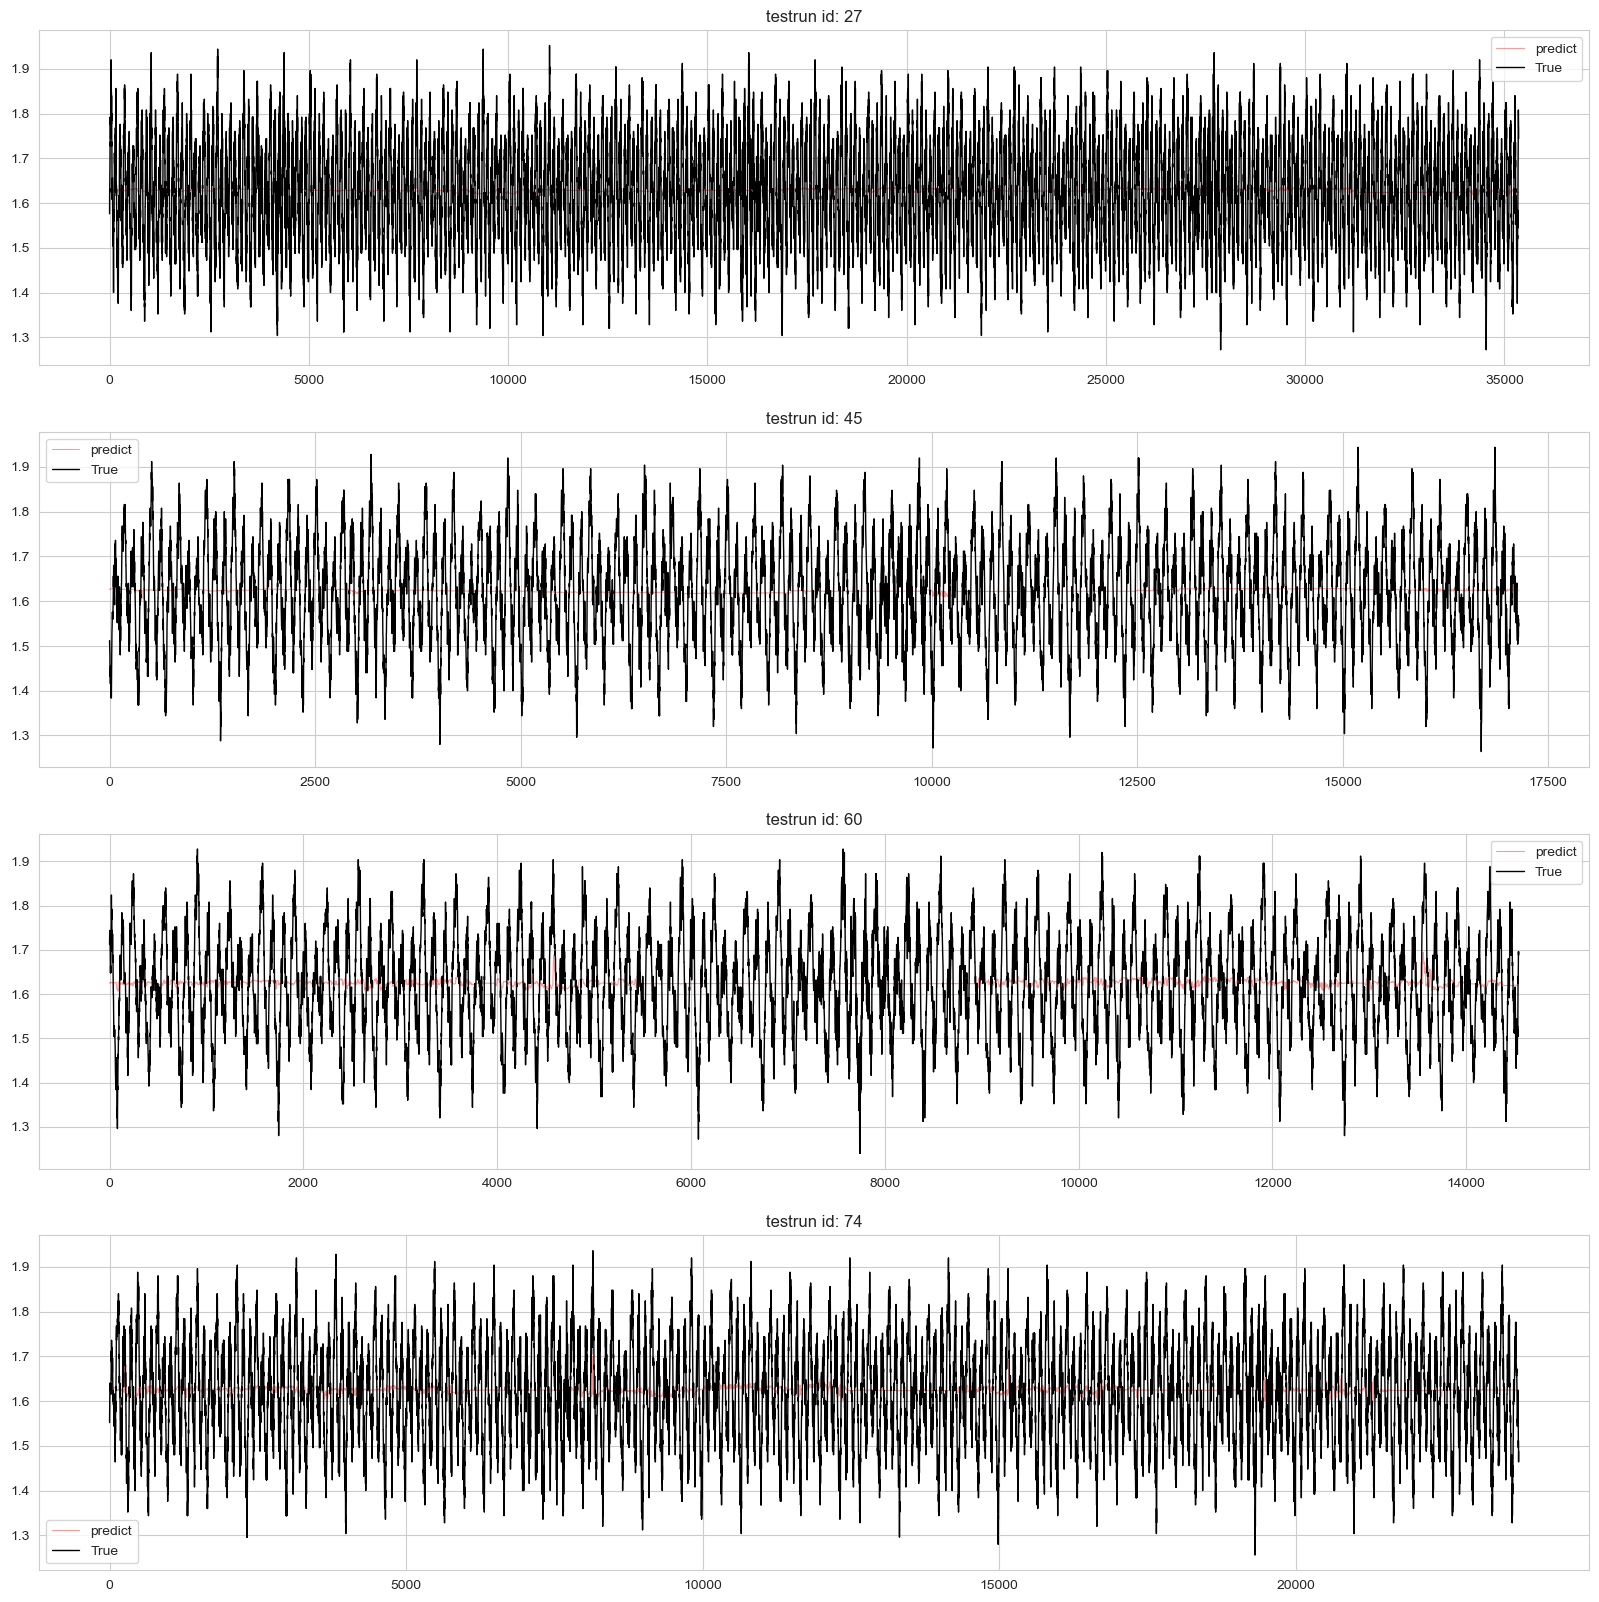

In [23]:
# plot the true vs predicted values for multiple testruns
test_run_list = np.array([27,45,60,74])
#test_run_list = np.random.choice(profile_id_list, size=4, replace=False)]
output_value = 'CH1'
model = NN_reg_model

with sns.axes_style("whitegrid"):    
    fig, axs = plt.subplots(len(test_run_list),1,figsize=(20,len(test_run_list)*5),squeeze=False)
    
    for i in range(0,len(test_run_list)):
        X_plot = dataset.drop('torque', axis=1).loc[dataset['testrun_id'] == test_run_list[i],'ambient':'i_q'].values 
        y_plot = dataset.loc[dataset['testrun_id'] == test_run_list[i],output_value].values 
        y_pred_plot = model.predict(X_plot)

        time = np.linspace(0, y_plot.shape[0],num=y_plot.shape[0])
        axs[i,0].plot(time,y_pred_plot,label='predict',color='red',alpha=0.4,linewidth=0.8)
        axs[i,0].plot(time,y_plot,label='True',color='black',linewidth=1)
        axs[i,0].legend(loc='best')
        axs[i,0].set_title("testrun id: {0}".format(test_run_list[i]))
    plt.show()   

348/348 [==============================] - 0s 1ms/step


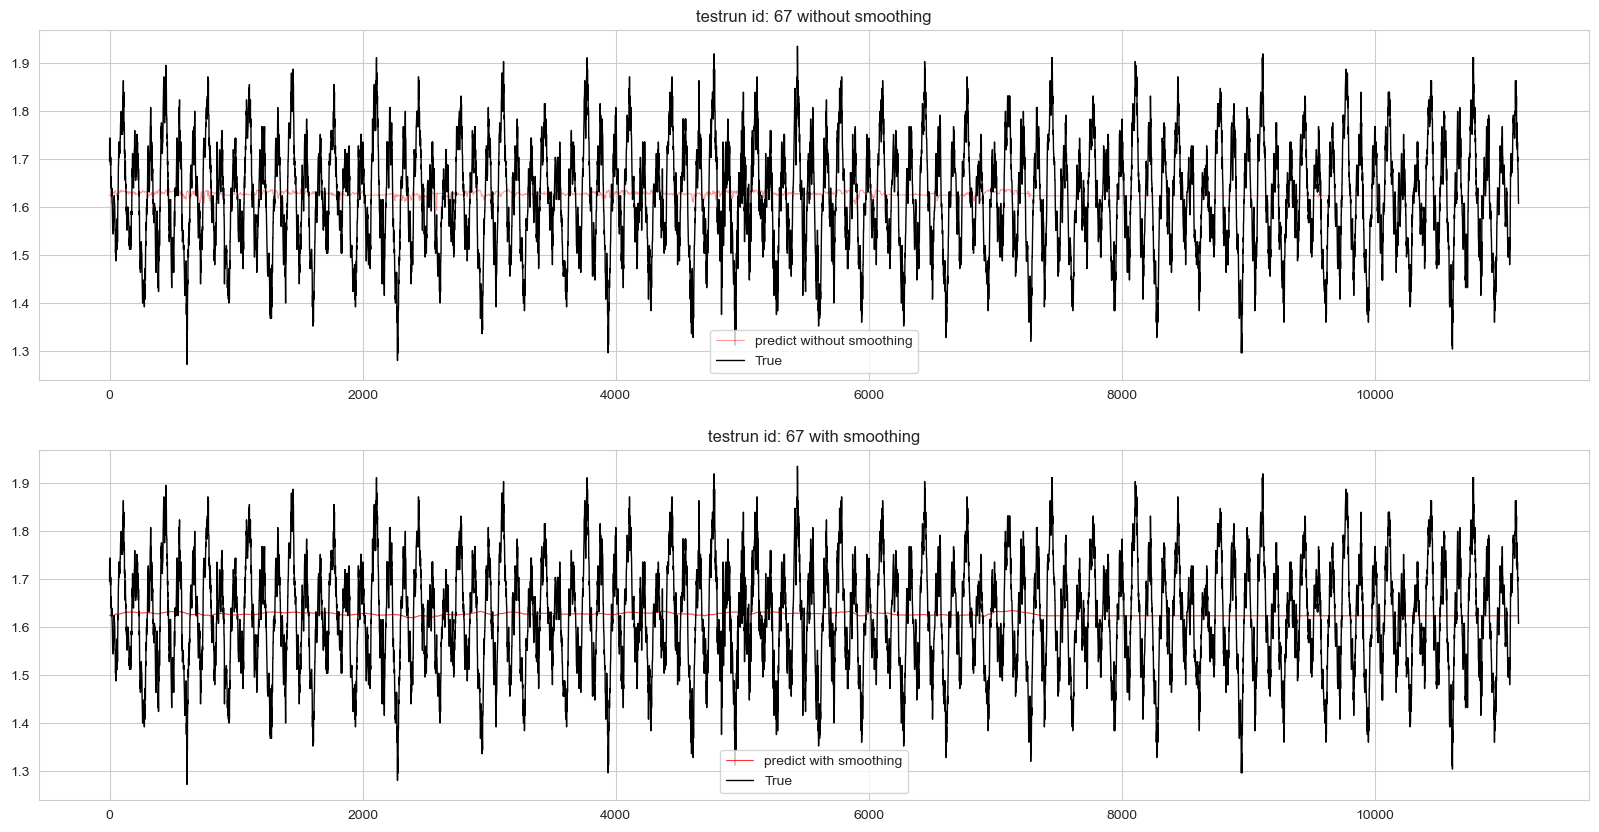

metrics without moving average smoothing:
MSE: 0.012277078907157644
MAE: 0.09080735982134627
metrics with moving average smoothing:
MSE: 0.0122641292640856
MAE: 0.09075300053546301


In [24]:
# plot the true vs predicted values for a choosen testrun without and with moving average smoothing:
testrun_id = choosen_example_testrun
output_value = 'CH1'
model = NN_reg_model
moving_average_window = 100

X_plot = dataset.drop('torque', axis=1).loc[dataset['testrun_id'] == testrun_id,'ambient':'i_q'].values 
y_plot = dataset.loc[dataset['testrun_id'] == testrun_id,output_value].values 
y_pred_plot = model.predict(X_plot).flatten()
y_pred_plot_smooth = bn.move_mean(y_pred_plot,moving_average_window,1)
time = np.linspace(0, y_plot.shape[0],num=y_plot.shape[0])

with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(20, 10))
    
    ax1 = fig.add_subplot(211)
    ax1.plot(time,y_pred_plot,label='predict without smoothing',color='red',alpha=0.4,linewidth=0.8)
    ax1.plot(time,y_plot,label='True',color='black',linewidth=1)
    ax1.legend(loc='best')
    ax1.set_title("testrun id: {0} without smoothing".format(testrun_id))
    
    ax2 = fig.add_subplot(212)
    ax2.plot(time,y_pred_plot_smooth,label='predict with smoothing',color='red',alpha=0.8,linewidth=0.8)
    ax2.plot(time,y_plot,label='True',color='black',linewidth=1)
    ax2.legend(loc='best')
    ax2.set_title("testrun id: {0} with smoothing".format(testrun_id))
    
    plt.show()

# Calculate MSE and MAE for the choosen testrun without and with moving average smoothing:
MSE_RFR_model = mean_squared_error(y_plot, y_pred_plot)
MAE_RFR_model = mean_absolute_error(y_plot, y_pred_plot)
print("metrics without moving average smoothing:")
print("MSE: {0}".format(MSE_RFR_model))
print("MAE: {0}".format(MAE_RFR_model))
MSE_RFR_model = mean_squared_error(y_plot, y_pred_plot_smooth)
MAE_RFR_model = mean_absolute_error(y_plot, y_pred_plot_smooth)
print("metrics with moving average smoothing:")
print("MSE: {0}".format(MSE_RFR_model))
print("MAE: {0}".format(MAE_RFR_model))

When we compare the Feed forward neural network with the Random Forest Regressor we can conclude that the neural network does not outperform the Random Forest in correctly predicting the stator temperature. (We could probably increase the performance by tweaking the neural network, but it doesn't seem very feasable to use a more complex solution like a Feed forward neural network when we achieve a descent and comparable performance using the Random Forest Regressor.)

## LSTM

We already discovered that the stator temperature is not only influenced by the current input variables but also by the previous states. We will therefore try to train an LSTM and check if it outperforms our earlier trained Random Forest.

In order to be able to train the LSTM we will need to transform our dataset to a 3D input matrix which includes a time window for every inputvalue per sample. 


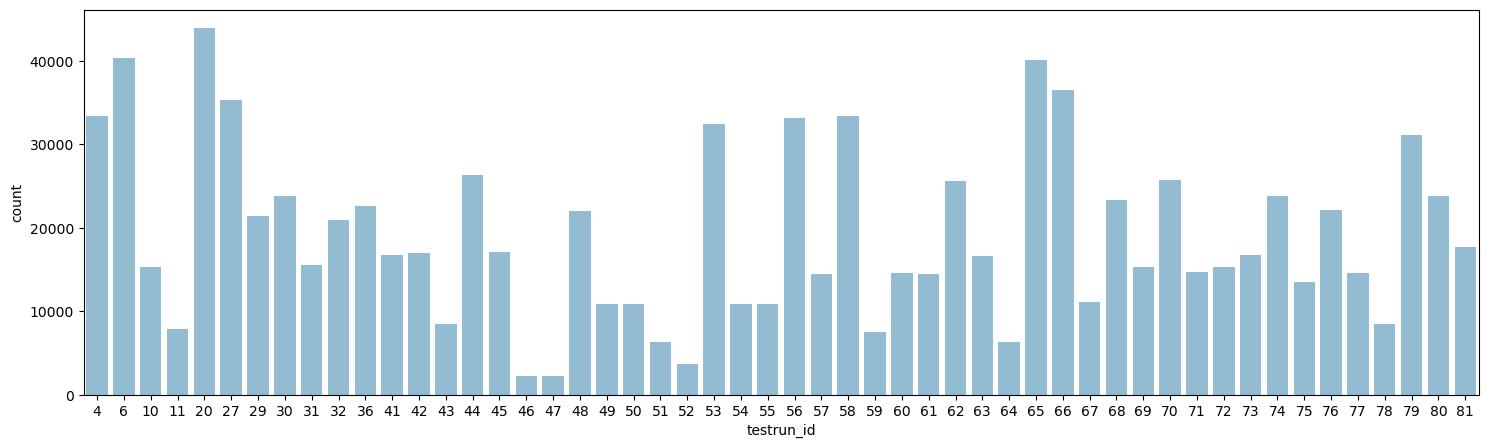

In [25]:
# plot the amount of samples per testrun
plt.figure(figsize=(18,5))
sns.countplot(x="testrun_id", data=dataset,color=sns.color_palette("Blues")[2])
plt.show()

In [26]:
# find the testrun with the least amount of samples
max_batch_size = dataset.testrun_id.value_counts().min()
profile_id_list = dataset.testrun_id.unique()
print("list of testruns:")
print(testrun_id_list)
print("smallest amount of samples in one testrun: {0}".format(max_batch_size))
print("testrun with smallest amount of samples: {0}".format(dataset.testrun_id.value_counts().idxmin()))

list of testruns:
[79 57 69 80 62 71 66 56]
smallest amount of samples in one testrun: 2175
testrun with smallest amount of samples: 47


As shown in the plot above, the length of the various testruns varies. This is important to keep in mind when composing our time windows because we can not allow the time windows to overlap 2 or more testruns. The function below will therefore only take time windows from one testrun as long as enough samples are present in that specific run, otherwise it will need to proceed to the next testrun until we have the required amount of samples with it's corresponding time windows.
Furthermore the function will allow us to define a sample rate for taking the samples in the testruns.

In [27]:
# function to create time-step windows for LSTM

def sliding_window(testrun_id_list,max_sample_count,sample_rate=1,window_size=100):
    # profile_id_list: list of testruns we want to use to extract our samples
    # max_sample_count: the total amount of samples we want in our trainingset
    # sample rate: amount of samples to skip between the previous and next sample
    # window_size: amount of time steps (samples in the past) the window contains
    
    nr_of_features = 7 #number of columns minus 'stator_winding','profile_id'
    sample_count = 0

    i = 0
    X = np.zeros((max_sample_count,window_size,nr_of_features))
    y = np.zeros((max_sample_count))

    for testrun_id in testrun_id_list:
        temp=(dataset[dataset['testrun_id']==testrun_id]).iloc[lambda x: x.index % sample_rate==0]     
        temp_y = temp['CH1']
        temp_X = temp.drop('torque', axis=1).loc[:,'ambient':'i_q']
    
        i=0
        while i < len(temp_X)-window_size and sample_count < max_sample_count:
            X[sample_count] = temp_X.iloc[i:i+window_size]
            y[sample_count] = temp_y.iloc[i+window_size]
            sample_count +=1
            i +=1
    return (X,y) 
        

In [28]:
# split the testruns in a training and testset
testrun_id_list_train ,testrun_id_list_test = train_test_split(testrun_id_list,test_size=0.3)
print("the list of testruns used for extracting the training sample windows:")
print(testrun_id_list_train)
print("the list of testruns used for extracting the testing sample windows:")
print(testrun_id_list_test)

the list of testruns used for extracting the training sample windows:
[66 69 79 80 56]
the list of testruns used for extracting the testing sample windows:
[57 62 71]


Now we have prepared the trainingsdata, we can start training our LSTM.

In [29]:
# constructing and training the LSTM
window_Size = 100
sample_amount = 5000
sample_rate = 10
epoch= 200
b_size = 500

X_train, y_train = sliding_window(testrun_id_list_train,sample_amount,sample_rate,window_Size)
X_test, y_test = sliding_window(testrun_id_list_test,sample_amount,sample_rate,window_Size)

LSTM_model = Sequential()
LSTM_model.add(LSTM(128, input_shape = (window_Size,7),return_sequences=True))
LSTM_model.add(LSTM(64, return_sequences=False))
LSTM_model.add(Dense(32, activation='relu'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(16, activation='relu'))
LSTM_model.add(Dense(8, activation='relu'))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mean_squared_error', optimizer='adam',metrics = ["mean_squared_error"])
history = LSTM_model.fit(X_train,y_train,validation_split=0.33, epochs = epoch, batch_size = b_size, verbose = 0)

KeyboardInterrupt: 

In [ ]:
#plot the history of the model accuracy during training
plt.figure(figsize=(18,6))
ax1=plt.subplot(1, 2, 1)
ax1=plt.plot(history.history['mean_squared_error'],color='blue')
ax1=plt.plot(history.history['val_mean_squared_error'],color='red',alpha=0.5)
ax1=plt.title('model accuracy')
ax1=plt.ylabel('accuracy')
ax1=plt.xlabel('epoch')
ax1=plt.legend(['train', 'test'], loc='upper left')

# plot the history of the model loss during training
ax2=plt.subplot(1, 2, 2)
ax2=plt.plot(history.history['loss'],color='blue')
ax2=plt.plot(history.history['val_loss'],color='red',alpha=0.5)
ax2=plt.title('model loss')
ax2=plt.ylabel('loss')
ax2=plt.xlabel('epoch')
ax2=plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Calculate MSE and MAE of the entire testset
y_pred_LSTM = LSTM_model.predict(X_test)
LSTM_MSE = mean_squared_error(y_test, y_pred_LSTM)
LSTM_MAE = mean_absolute_error(y_test, y_pred_LSTM)
print("MSE: {0}".format(LSTM_MSE))
print("MAE: {0}".format(LSTM_MAE))

In [ ]:
# plot the true vs predicted values for multiple testruns
test_run_list = np.array([27,45,60,74])
#test_run_list = np.random.choice(profile_id_list, size=4, replace=False)]
output_value = 'CH1'
model = LSTM_model

window_Size = 100
sample_rate = 10

with sns.axes_style("whitegrid"):    
    fig, axs = plt.subplots(len(test_run_list),1,figsize=(20,len(test_run_list)*5),squeeze=False)
    
    for i in range(0,len(test_run_list)):
        sample_amount = (len(dataset[dataset['testrun_id']==test_run_list[i]])-window_Size)//sample_rate
        X_plot, y_plot = sliding_window([test_run_list[i]],sample_amount,sample_rate,window_Size)
        y_pred_plot = model.predict(X_plot)

        time = np.linspace(0, y_plot.shape[0],num=y_plot.shape[0])
        axs[i,0].plot(time,y_pred_plot,label='predict',color='red',alpha=0.4,linewidth=0.8)
        axs[i,0].plot(time,y_plot,label='True',color='black',linewidth=1)
        axs[i,0].legend(loc='best')
        axs[i,0].set_title("testrun id: {0}".format(test_run_list[i]))
    plt.show()   

In [ ]:
# plot the true vs predicted values for one run
test_run_list = np.array([choosen_example_testrun])
#test_run_list = np.random.choice(profile_id_list, size=4, replace=False)]
output_value = 'CH1'
model = LSTM_model

window_Size = 100
#sample_amount = 10000
sample_rate = 10

with sns.axes_style("whitegrid"):    
    fig, axs = plt.subplots(len(test_run_list),1,figsize=(20,len(test_run_list)*5),squeeze=False)
    
    for i in range(0,len(test_run_list)):
        sample_amount = (len(dataset[dataset['testrun_id']==test_run_list[i]])-window_Size)//sample_rate
        X_plot, y_plot = sliding_window([test_run_list[i]],sample_amount,sample_rate,window_Size)
        y_pred_plot = model.predict(X_plot)

        time = np.linspace(0, y_plot.shape[0],num=y_plot.shape[0])
        axs[i,0].plot(time,y_pred_plot,label='predict',color='red',alpha=0.4,linewidth=0.8)
        axs[i,0].plot(time,y_plot,label='True',color='black',linewidth=1)
        axs[i,0].legend(loc='best')
        axs[i,0].set_title("testrun id: {0}".format(test_run_list[i]))
    plt.show()
    
print("MSE: {0}".format(mean_squared_error(y_plot, y_pred_plot)))
print("MAE: {0}".format(mean_absolute_error(y_plot, y_pred_plot)))

# Conclusion
When we compare the performance of the three models, we can conclude that in this case the Random Forest Regressor with moving average smoothing outperforms both a classic Feedforward Neural Network and an LSTM. The underperforming of the two deep learning models can probably be reduced by changing the models structure and hyperparameters. 
However, because the Random Forest Regressor with moving average smoothing performs more than adequate in predicting the stator temperature (as the various examples below show) using a relative modest model like this is preferred above more computational and memory intensive alternatives like an NN or LSTM.  

In [ ]:
# plot the true vs predicted values for multiple testruns for the Random Forest Regressor
#test_run_list = np.array([27,45,60,74])
test_run_list = np.random.choice(testrun_id_list, size=4, replace=False)
output_value = 'CH1'
model = RFR_model
moving_average = 100

with sns.axes_style("whitegrid"):    
    fig, axs = plt.subplots(len(test_run_list),1,figsize=(20,len(test_run_list)*5),squeeze=False)
    
    for i in range(0,len(test_run_list)):
        X_plot = dataset.drop('torque', axis=1).loc[dataset['testrun_id'] == test_run_list[i],'ambient':'i_q'].values 
        y_plot = dataset.loc[dataset['testrun_id'] == test_run_list[i],output_value].values 
        y_pred_plot = bn.move_mean(model.predict(X_plot),moving_average_window,1)

        time = np.linspace(0, y_plot.shape[0],num=y_plot.shape[0])
        axs[i,0].plot(time,y_pred_plot,label='predict',color='red',alpha=0.4,linewidth=0.8)
        axs[i,0].plot(time,y_plot,label='True',color='black',linewidth=1)
        axs[i,0].legend(loc='best')
        axs[i,0].set_title("testrun id: {0}".format(test_run_list[i]))
    plt.show()   